## Get Data

In [55]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [56]:
# what types are the features?
type(X)

numpy.ndarray

In [57]:
# how big is the dataset?
X.shape

(10000, 2)

In [58]:
# shape of labels?
y.shape

(10000,)

In [59]:
# flatten into a column
y = y.reshape(-1,1)

In [60]:
# organize into pandas
import pandas as pd
import numpy as np

data = pd.DataFrame(data = np.append(X, y, 1), columns = ['X1','X2','label'])

In [61]:
from sklearn.model_selection import train_test_split

# make train/test set
train, test = train_test_split(data, train_size = 0.85, random_state = 25)

In [62]:
type(train)

pandas.core.frame.DataFrame

In [63]:
# make X and y
X_train = train.drop('label', axis = 1)
y_train = train['label']

X_test = test.drop('label', axis = 1)
y_test = test['label']

## Visualize X_train

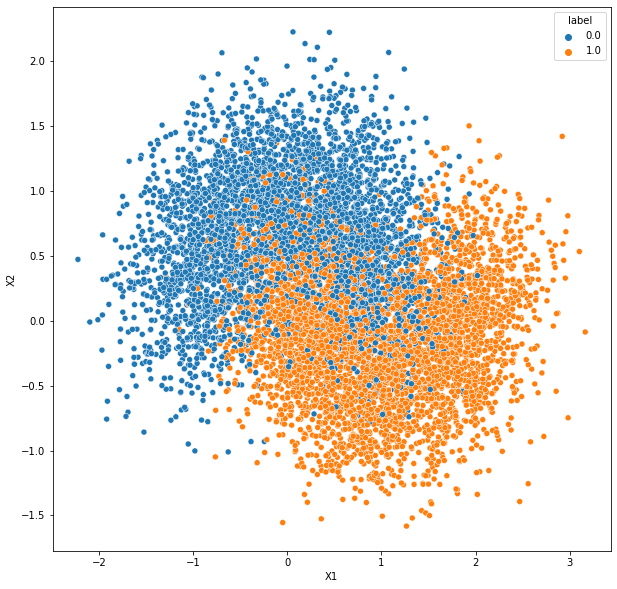

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fig, axs = plt.subplots(1,1)
fig.set_size_inches(10,10)

g = sns.scatterplot(data = train, x = 'X1', y = 'X2', hue = 'label')
plt.show()

# Baseline with Decision Tree

In [65]:
# import model
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state = 18)

In [66]:
# train model
model.fit(X_train.values, y_train.values)

DecisionTreeClassifier(random_state=18)

In [67]:
# make predictions and show accuracy
import numpy as np

y_train_preds = model.predict(X_train.values)
acc = np.mean(y_train == y_train_preds)

print('Accuracy on Training Set: {:.2%}'.format(acc))

Accuracy on Training Set: 100.00%


This high of accuracy on the training set must indicate that the model is overfitting. Let's see the accuracy on the test set.

In [68]:
y_test_preds = model.predict(X_test.values)
acc = np.mean(y_test == y_test_preds)

print('Accuracy on Test Set: {:.2%}'.format(acc))

Accuracy on Test Set: 80.60%


Above we can see that the accuracy on the test set is much lower than the training set. This is a clear indicator of overfitting. We will reduce this by using grid search.

Before that, let's visualize the decision boundary for this initial model.

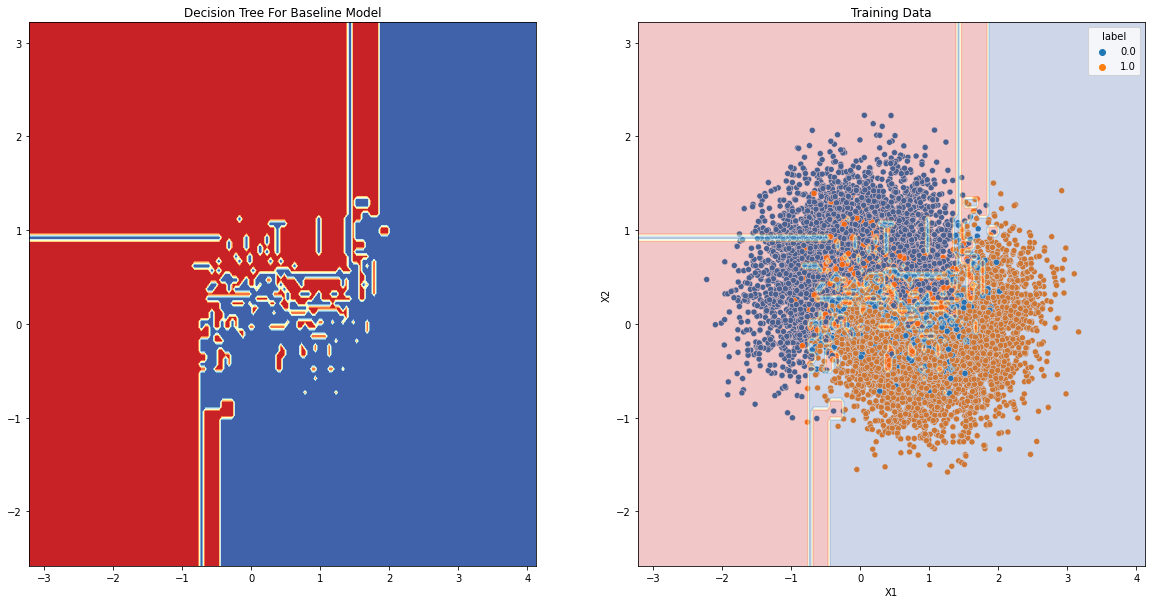

In [75]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,10)

plot_step = 0.05

x_min, x_max = train['X1'].min() - 1, train['X1'].max() + 1
y_min, y_max = train['X2'].min() - 1, train['X2'].max() + 1

xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )


Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
axs[0].set_title('Decision Tree For Baseline Model')

g = sns.scatterplot(data = train, x = 'X1', y = 'X2', hue = 'label', ax = axs[1])
axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha = 0.25)
axs[1].set_title('Training Data')

plt.show()

Above, we can see that the decision boundary has "islands", which typically mean that it is overfitting the data set. Now let's create a model that is not overfitting by using Grid Search CV.

## Grid Search

In [119]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_grid = {'criterion' : ['gini', 'entropy'],
                'splitter' : ['best', 'random'],
                'max_depth' : randint(2, 100),
                'min_samples_split' : uniform(0,1),
                'min_samples_leaf' : uniform(0,0.5),
                'max_features' : ['auto','sqrt','log2',None],
                'max_leaf_nodes' : randint(2,100)}

model_optimized = RandomizedSearchCV(DecisionTreeClassifier(random_state = 10), param_distributions = param_grid, n_iter = 1000, cv = 5, scoring = 'accuracy', random_state = 48)

In [120]:
model_optimized.fit(X_train.values, y_train.values)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10),
                   n_iter=1000,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1D1680FD0>,
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1D0D914C0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1D1680F70>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1D108F430>,
                                        'splitter': ['best', 'random']},
                   random_state=48, scoring='accuracy')

In [121]:
model_optimized.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 51,
 'min_samples_leaf': 0.02060232383498073,
 'min_samples_split': 0.3215274507597906,
 'splitter': 'best'}

In [122]:
model_optimized.best_score_

0.8549411764705882

Let's visualize the decision boundary for this model I anticipate there will be less islands.

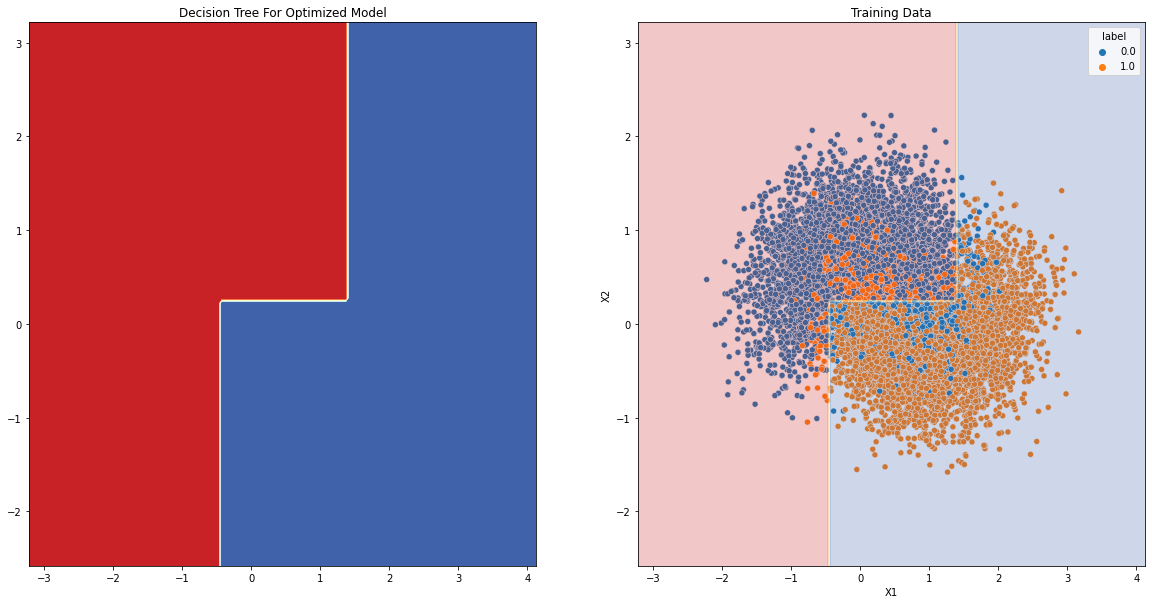

In [125]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,10)

plot_step = 0.05

x_min, x_max = train['X1'].min() - 1, train['X1'].max() + 1
y_min, y_max = train['X2'].min() - 1, train['X2'].max() + 1

xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )


Z = model_optimized.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
axs[0].set_title('Decision Tree For Optimized Model')

g = sns.scatterplot(data = train, x = 'X1', y = 'X2', hue = 'label', ax = axs[1])
axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha = 0.25)
axs[1].set_title('Training Data')

plt.show()

We can see above that this model generalizes much better than the baseline model. Although it is doing a lot of misidenfitications, the accuracy from the training to test set should be much smaller compared to the baseline model.

In [124]:
y_test_preds = model_optimized.predict(X_test.values)

acc = np.mean(y_test == y_test_preds)
print('Optimized Model Accuracy on Test Set: {:.2%}'.format(acc))

Optimized Model Accuracy on Test Set: 86.20%


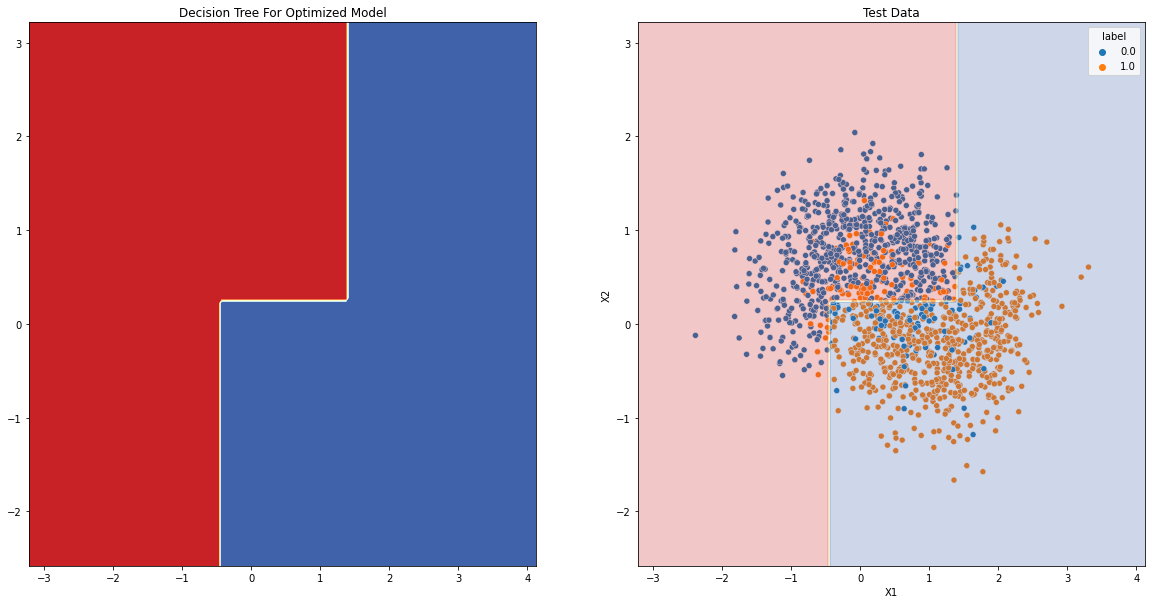

In [126]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,10)

plot_step = 0.05

x_min, x_max = train['X1'].min() - 1, train['X1'].max() + 1
y_min, y_max = train['X2'].min() - 1, train['X2'].max() + 1

xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )


Z = model_optimized.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
axs[0].set_title('Decision Tree For Optimized Model')

g = sns.scatterplot(data = test, x = 'X1', y = 'X2', hue = 'label', ax = axs[1])
axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha = 0.25)
axs[1].set_title('Test Data')

plt.show()